### Imports

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import os
import pandas as pd
import sys

import torch
import torch.nn          as nn
from torch.utils.data    import Dataset, DataLoader
from torch.optim         import Adam

from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import training     as tr

In [2]:
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'

idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')

molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

### Torch settings

In [3]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100

## Data

In [4]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

In [5]:
## Make PyTorch dataset
train = ds.MyDataset(dir=dir, scale = "norm")
test  = ds.MyDataset(dir=dir, scale = "norm", train = False)
 
print('total # of samples:',len(train)+len(test))
print('# training samples:',len(train))
print('# testing samples: ',len(test) )
print('            ratio: ',np.round(len(test)/(len(train)+len(test)),2))


total # of samples: 2187
# training samples: 1530
# testing samples:  657
            ratio:  0.3


In [6]:
## Make PyTorch tensor objects from the data set to train

kwargs = {'num_workers': 1, 'pin_memory': True} 

data_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True ,  **kwargs)
test_loader = DataLoader(dataset=test , batch_size=len(test) , shuffle=False,  **kwargs)


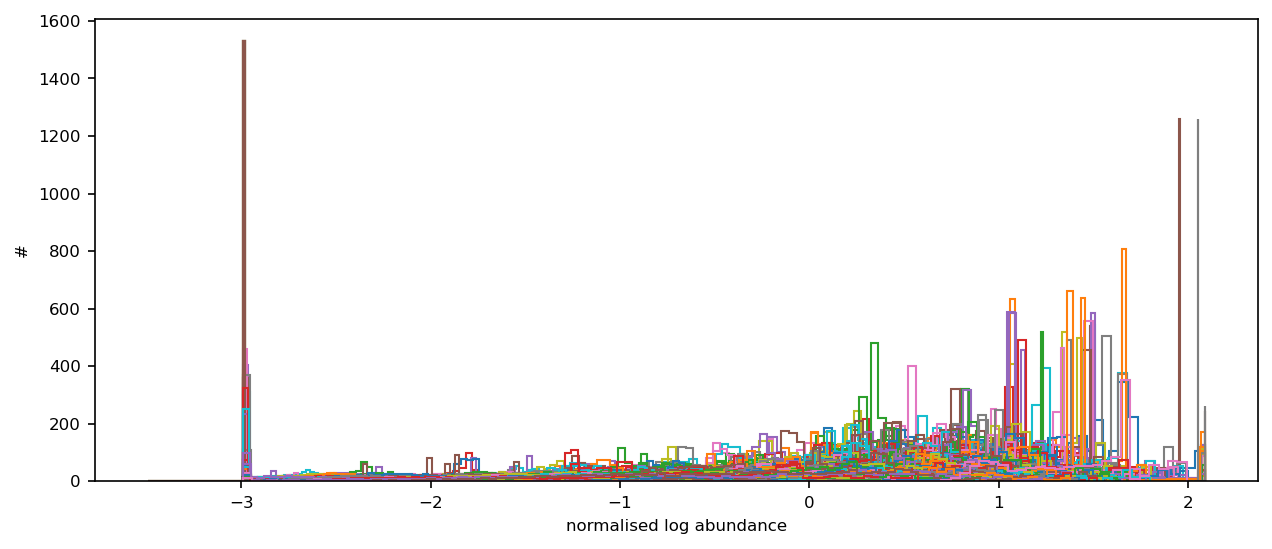

In [7]:
#pl.plot_hist(train.df)

## Model 1

### model hyperparameters

In [8]:
## Set up training hyperparams
lr = 1e-3                   ## learning rate
epochs = 20

### architecture

In [9]:
## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim
nb_hidden = 2
type = 'straight'

In [10]:
## Build model

encoder = ae.Encoder( input_dim, hidden_dim, latent_dim, nb_hidden=nb_hidden, type = type)
encoder.set_name('Encoder')
decoder = ae.Decoder(latent_dim, hidden_dim, output_dim, nb_hidden=nb_hidden, type = type)
decoder.set_name('Decoder')
model = ae.Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU
model.set_name('model 1')


In [11]:
ae.print_overview(encoder)
ae.print_overview(decoder)

Encoder:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |       3010
  output |    10 |          /
-----------------------------------
         |       |     324310
Decoder:
       # | nodes | parameters
-----------------------------------
   input |    10 |       3300
  hidden |   300 |      90300
  hidden |   300 |      90300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     324768


### Training & testing

In [12]:
## Training & validating model

loss_train_all, loss_test_all = tr.Train(model, lr, data_loader, test_loader, epochs, DEVICE)
x_test, x_test_hat, loss = tr.Test(model, test_loader, DEVICE)


model 1:
	Epoch 20 complete! 	Average loss train:  0.01867323846090585 	Average loss test:  0.0165352374315261846
DONE!



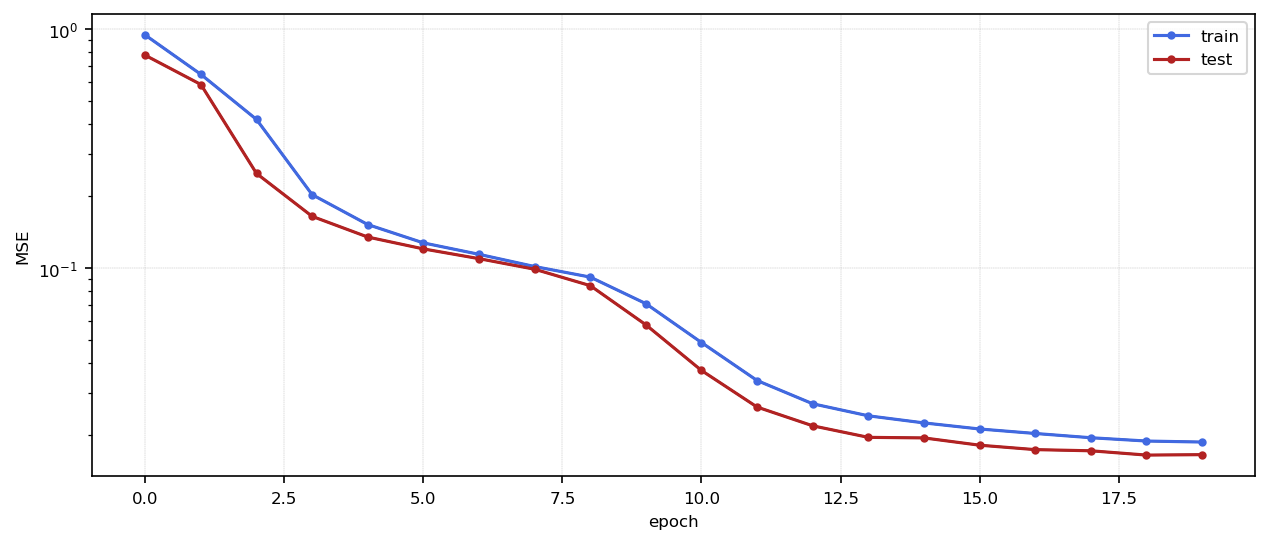

In [13]:
pl.plot_loss(loss_train_all, loss_test_all)

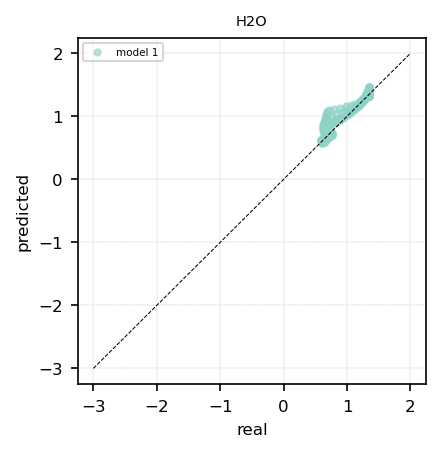

In [15]:
pl.plot_compare(x_test,[x_test_hat], [model],molecs,'H2O')


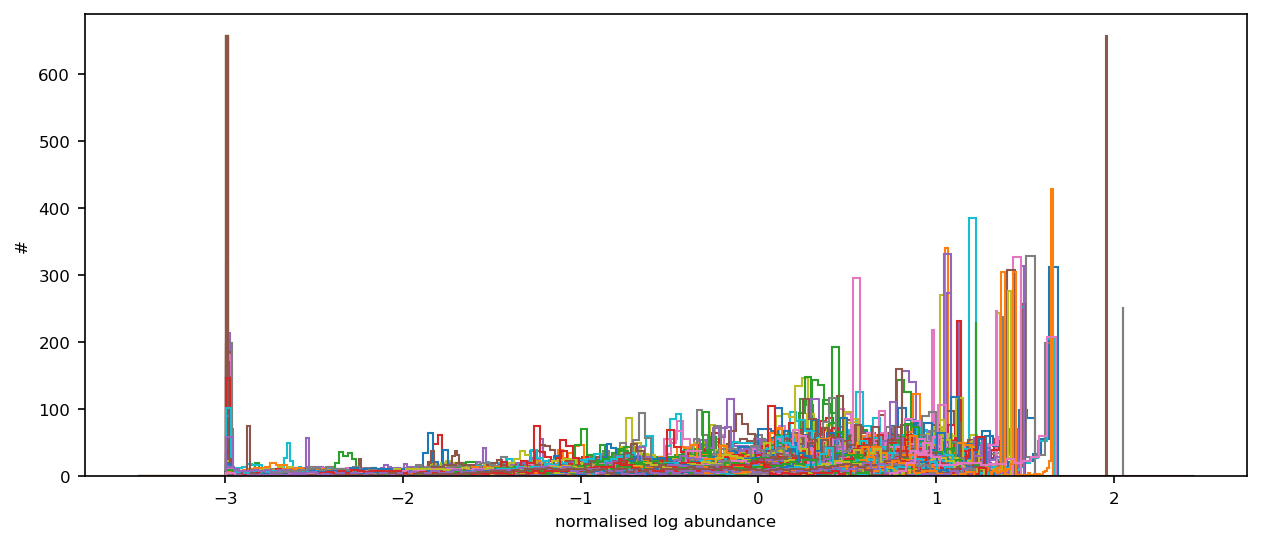

In [16]:
# pl.plot_hist(x_test)

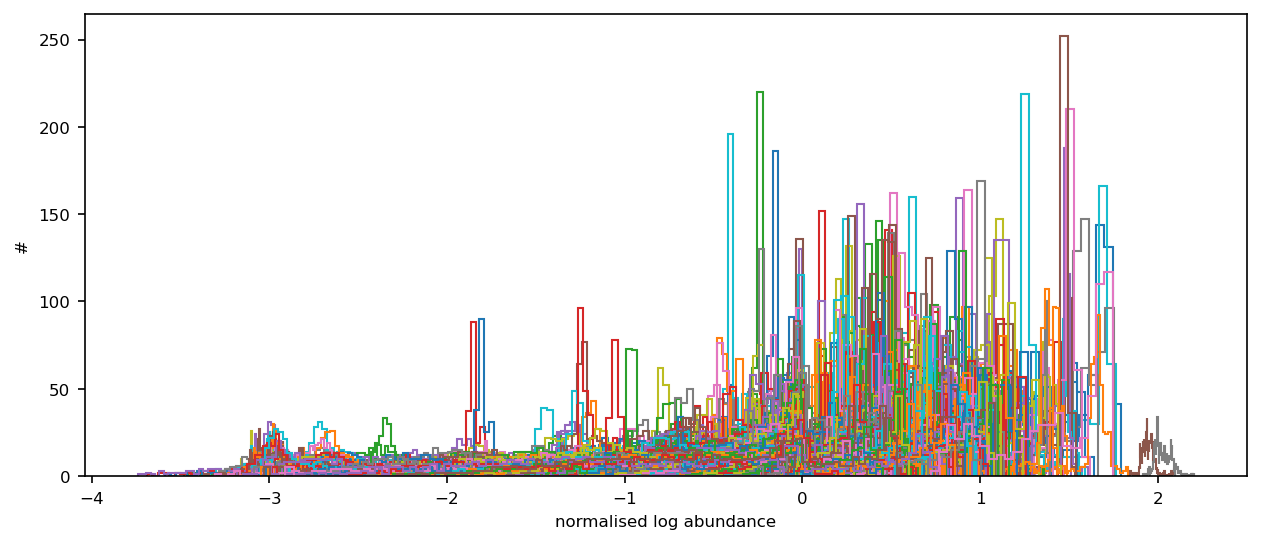

In [17]:
# pl.plot_hist(x_test_hat)

## Comparison of abundance profile

In [18]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

In [19]:
rad, real, pred = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')

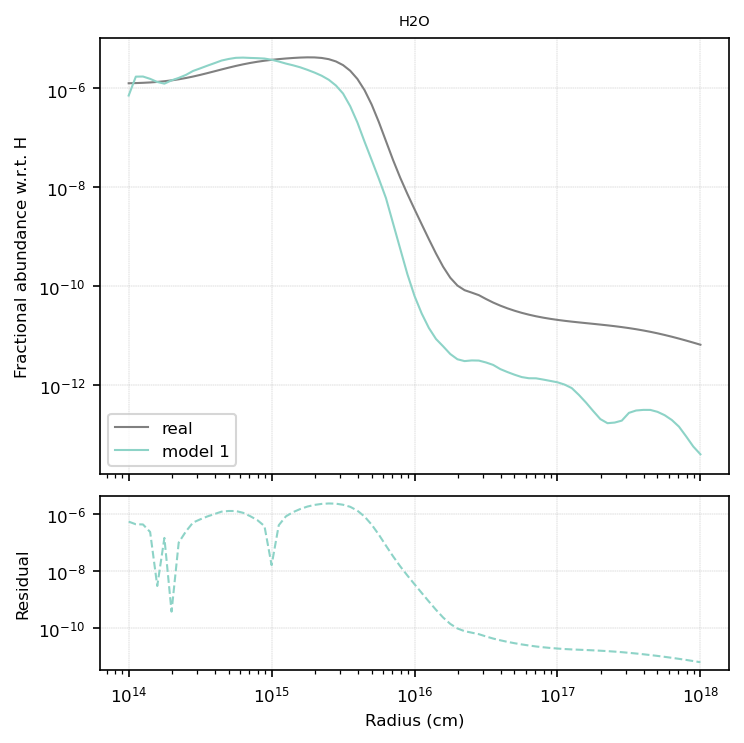

In [20]:
pl.plot_fracs_profile(rad, real, [pred], [model], molecs, 'H2O')